In [1]:
from google.colab import files
uploaded = files.upload()  # Choose your ZIP file (e.g., legal_clause_dataset.zip)


Saving archive.zip to archive.zip


In [2]:
import zipfile
import os

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("legal_clause_dataset")

# Check extracted files
os.listdir("legal_clause_dataset")


['organization.csv',
 'independent-contractor.csv',
 'registration-rights.csv',
 'amendments-and-waivers.csv',
 'term-of-employment.csv',
 'indebtedness.csv',
 'transfer.csv',
 'now-therefore.csv',
 'time.csv',
 'r-e-c-i-t-a-l-s.csv',
 'conditions-precedent.csv',
 'entire-agreement-amendments.csv',
 'organization-and-qualification.csv',
 'litigation.csv',
 'authorization.csv',
 'obligations-absolute.csv',
 'payment-of-taxes.csv',
 'witnesseth.csv',
 'seniority.csv',
 'trustee-may-file-proofs-of-claim.csv',
 'the-closing.csv',
 'termination-of-agreement.csv',
 'purpose.csv',
 'payment.csv',
 'miscellaneous-provisions.csv',
 'remedies-cumulative.csv',
 'purchase-price.csv',
 'taxes.csv',
 'financial-covenants.csv',
 'dividends.csv',
 'set-off.csv',
 'section-headings.csv',
 'bankruptcy.csv',
 'judgments.csv',
 'employment.csv',
 'duties.csv',
 'compliance-with-law.csv',
 'survival.csv',
 'meetings.csv',
 'witnesseth-that.csv',
 'maintenance-of-insurance.csv',
 'submission-to-jurisdiction

In [3]:
import pandas as pd
import os

clause_data = {}
for file in os.listdir("legal_clause_dataset"):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join("legal_clause_dataset", file))
        category = file.replace(".csv", "")
        clause_data[category] = df['clause_text'].dropna().tolist()

print("Loaded categories:", list(clause_data.keys()))
print("Example clause:", clause_data[list(clause_data.keys())[0]][0])

Loaded categories: ['organization', 'independent-contractor', 'registration-rights', 'amendments-and-waivers', 'term-of-employment', 'indebtedness', 'transfer', 'now-therefore', 'time', 'r-e-c-i-t-a-l-s', 'conditions-precedent', 'entire-agreement-amendments', 'organization-and-qualification', 'litigation', 'authorization', 'obligations-absolute', 'payment-of-taxes', 'witnesseth', 'seniority', 'trustee-may-file-proofs-of-claim', 'the-closing', 'termination-of-agreement', 'purpose', 'payment', 'miscellaneous-provisions', 'remedies-cumulative', 'purchase-price', 'taxes', 'financial-covenants', 'dividends', 'set-off', 'section-headings', 'bankruptcy', 'judgments', 'employment', 'duties', 'compliance-with-law', 'survival', 'meetings', 'witnesseth-that', 'maintenance-of-insurance', 'submission-to-jurisdiction', 'duration-of-agreement', 'closing-date', 'applicable-law', 'permits', 'certain-definitions', 'support', 'disputes', 'insurance', 'representations-and-warranties', 'survival-of-represe

In [4]:
import itertools
import random

pairs = []

# Positive pairs (similar): same file
for category, texts in clause_data.items():
    for (a, b) in itertools.combinations(texts[:10], 2):  # limit to first 10 for demo
        pairs.append((a, b, 1))

# Negative pairs (not similar): across files
categories = list(clause_data.keys())
for i, cat1 in enumerate(categories):
    for cat2 in categories[i+1:]:
        for a in random.sample(clause_data[cat1][:10], min(5, len(clause_data[cat1][:10]))):
            for b in random.sample(clause_data[cat2][:10], min(5, len(clause_data[cat2][:10]))):
                pairs.append((a, b, 0))

random.shuffle(pairs)
pairs_df = pd.DataFrame(pairs, columns=["clause1", "clause2", "label"])

print(pairs_df.shape)
pairs_df.head()


(1963150, 3)


,clause1,clause2,label
0,Marketing and Publicity. 4.1 …. shall not use ...,Term. The term of this Agreement will be ten (...,0
1,Covenants of the Company. The Company covenant...,Limitation of Liability. (a) The Sub-Adviser s...,0
2,Guaranty. (a) Any guaranty of any Obligations ...,No Third Party Beneficiaries. This Agreement s...,0
3,DURATION OF AGREEMENT. All agreements and obli...,Modifications. Custodian reserves the right to...,0
4,Closing Date. The date and time of the issuanc...,Specific Performance. The parties hereto agree...,0


In [5]:
pairs_df.to_csv("legal_clause_pairs.csv", index=False)
print("Saved as legal_clause_pairs.csv")


Saved as legal_clause_pairs.csv


In [6]:
import pandas as pd

pairs_df = pd.read_csv("legal_clause_pairs.csv")
print(pairs_df.shape)
pairs_df.head()


(1963150, 3)


,clause1,clause2,label
0,Marketing and Publicity. 4.1 …. shall not use ...,Term. The term of this Agreement will be ten (...,0
1,Covenants of the Company. The Company covenant...,Limitation of Liability. (a) The Sub-Adviser s...,0
2,Guaranty. (a) Any guaranty of any Obligations ...,No Third Party Beneficiaries. This Agreement s...,0
3,DURATION OF AGREEMENT. All agreements and obli...,Modifications. Custodian reserves the right to...,0
4,Closing Date. The date and time of the issuanc...,Specific Performance. The parties hereto agree...,0


In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_df, test_df = train_test_split(pairs_df, test_size=0.2, random_state=42)

print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)



# Combine both clause columns for fitting tokenizer
texts = pd.concat([train_df['clause1'], train_df['clause2']])

# Tokenize
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)


Train DataFrame shape: (1570520, 3)
Test DataFrame shape: (392630, 3)
Vocabulary size: 8374


In [8]:
max_len = 100  # you can adjust this depending on your dataset

def prepare_sequences(df):
    seq1 = tokenizer.texts_to_sequences(df['clause1'])
    seq2 = tokenizer.texts_to_sequences(df['clause2'])
    seq1 = pad_sequences(seq1, maxlen=max_len, padding='post', truncating='post')
    seq2 = pad_sequences(seq2, maxlen=max_len, padding='post', truncating='post')
    return seq1, seq2

X1_train, X2_train = prepare_sequences(train_df)
X1_test, X2_test = prepare_sequences(test_df)

y_train = train_df['label'].values
y_test = test_df['label'].values

print("X1_train shape:", X1_train.shape)
print("X2_train shape:", X2_train.shape)



X1_train shape: (1570520, 100)
X2_train shape: (1570520, 100)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Lambda
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

embedding_dim = 128
lstm_units = 64

def create_base_encoder(vocab_size, embedding_dim, max_len):
    input_seq = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_seq)
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding)
    dense = Dense(64, activation='relu')(lstm)
    model = Model(inputs=input_seq, outputs=dense)
    return model

base_encoder = create_base_encoder(vocab_size, embedding_dim, max_len)
base_encoder.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     1,071,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,178,944 (4.50 MB)

 Trainable params: 1,178,944 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define two inputs
input_a = Input(shape=(max_len,))
input_b = Input(shape=(max_len,))

# Encode both clauses using the same BiLSTM encoder
encoded_a = base_encoder(input_a)
encoded_b = base_encoder(input_b)

# Combine representations — absolute difference + multiplication
merged = concatenate([
    Lambda(lambda x: K.abs(x[0] - x[1]))([encoded_a, encoded_b]),
    tf.keras.layers.Multiply()([encoded_a, encoded_b])
])

# Add dense layers
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Build model
model_bilstm = Model(inputs=[input_a, input_b], outputs=output)
model_bilstm.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_bilstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 64)        │  1,178,944 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,187,265 (4.53 MB)

 Trainable params: 1,187,265 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

history = model_bilstm.fit(
    [X1_train, X2_train], y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64
)

# Predictions
y_pred_prob = model_bilstm.predict([X1_test, X2_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {auc:.3f}")


Epoch 1/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 500s 22ms/step - accuracy: 0.9963 - loss: 0.0177 - val_accuracy: 0.9999 - val_loss: 3.3789e-04
Epoch 2/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 488s 22ms/step - accuracy: 0.9999 - loss: 4.9532e-04 - val_accuracy: 0.9999 - val_loss: 3.8702e-04
Epoch 3/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 489s 22ms/step - accuracy: 0.9999 - loss: 3.1171e-04 - val_accuracy: 1.0000 - val_loss: 9.6756e-05
Epoch 4/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 498s 23ms/step - accuracy: 0.9999 - loss: 1.6627e-04 - val_accuracy: 1.0000 - val_loss: 7.2027e-05
Epoch 5/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 495s 22ms/step - accuracy: 1.0000 - loss: 1.6020e-04 - val_accuracy: 1.0000 - val_loss: 7.5331e-05
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 95s 8ms/step
Accuracy: 1.000
Precision: 0.998
Recall: 0.999
F1-Score: 0.998
ROC-AUC: 1.000


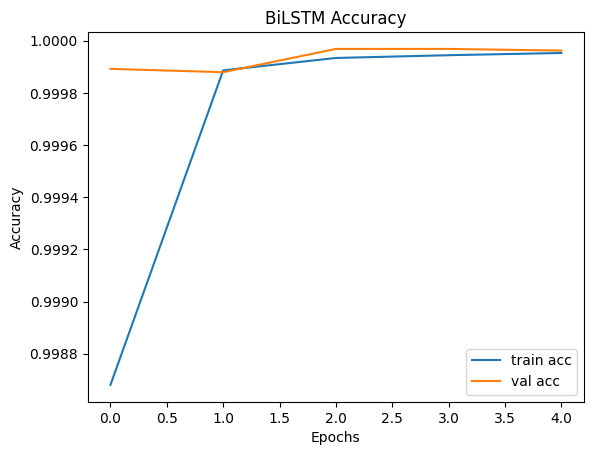

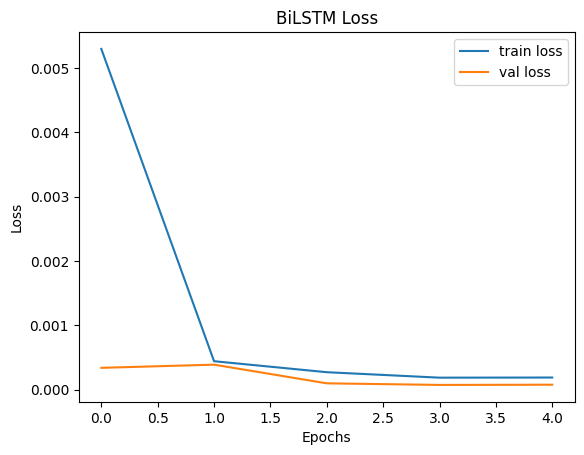

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('BiLSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('BiLSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x shape: (batch_size, time_steps, features)
        e = K.tanh(K.dot(x, self.W) + self.b)  # (batch_size, time_steps, 1)
        a = K.softmax(e, axis=1)               # attention weights
        output = x * a                         # apply weights
        return K.sum(output, axis=1)           # weighted sum


embedding_dim = 128
lm_units = 64
max_len = 100  # same as before

def create_attention_encoder(vocab_size, embedding_dim, max_len, lstm_units):
    input_seq = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_seq)
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    attn = Attention()(lstm)
    dense = Dense(64, activation='relu')(attn)
    model = Model(inputs=input_seq, outputs=dense)
    return model

attention_encoder = create_attention_encoder(vocab_size, embedding_dim, max_len, lstm_units)
attention_encoder.summary()
# Two inputs
input_a = Input(shape=(max_len,))
input_b = Input(shape=(max_len,))

# Encode both clauses using shared attention encoder
encoded_a = attention_encoder(input_a)
encoded_b = attention_encoder(input_b)

# Combine representations: absolute difference + element-wise multiplication
merged = concatenate([
    tf.keras.layers.Lambda(lambda x: K.abs(x[0] - x[1]))([encoded_a, encoded_b]),
    tf.keras.layers.Multiply()([encoded_a, encoded_b])
])

# Dense layers for final classification
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Build model
model_attention = Model(inputs=[input_a, input_b], outputs=output)
model_attention.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_attention.summary()
history_attn = model_attention.fit(
    [X1_train, X2_train], y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_prob = model_attention.predict([X1_test, X2_test])
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {auc:.3f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 128)       │     1,071,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 128)            │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,179,172 (4.50 MB)

 Trainable params: 1,179,172 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 64)        │  1,179,172 │ input_layer_7[0]… │
│ (Functional)        │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ functional_3[0][… │
│                     │                   │            │ functional_3[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 64)        │          0 │ functional_3[0][… │
│ (Multiply)          │                   │            │ functional_3[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,187,493 (4.53 MB)

 Trainable params: 1,187,493 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 526s 24ms/step - accuracy: 0.9931 - loss: 0.0372 - val_accuracy: 0.9997 - val_loss: 9.0459e-04
Epoch 2/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 530s 24ms/step - accuracy: 0.9997 - loss: 9.5227e-04 - val_accuracy: 0.9999 - val_loss: 3.8950e-04
Epoch 3/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 517s 23ms/step - accuracy: 0.9999 - loss: 4.0520e-04 - val_accuracy: 0.9999 - val_loss: 2.2634e-04
Epoch 4/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 565s 24ms/step - accuracy: 0.9999 - loss: 3.4568e-04 - val_accuracy: 0.9996 - val_loss: 0.0034
Epoch 5/5
22086/22086 ━━━━━━━━━━━━━━━━━━━━ 517s 23ms/step - accuracy: 0.9999 - loss: 5.3707e-04 - val_accuracy: 1.0000 - val_loss: 6.6119e-05
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 97s 8ms/step
Accuracy: 1.000
Precision: 0.999
Recall: 1.000
F1-Score: 1.000
ROC-AUC: 1.000


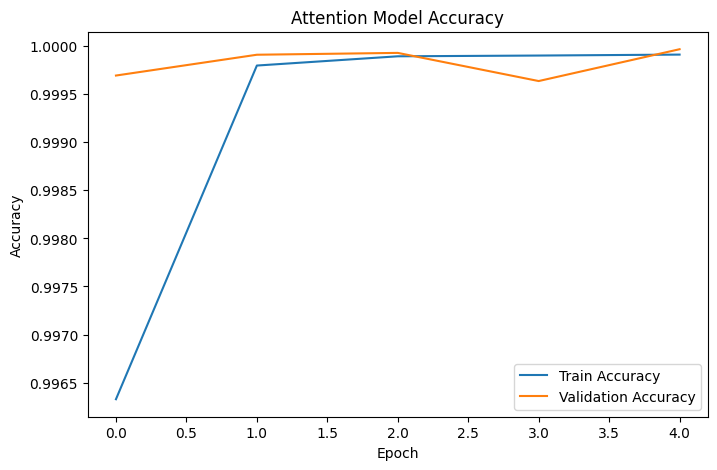

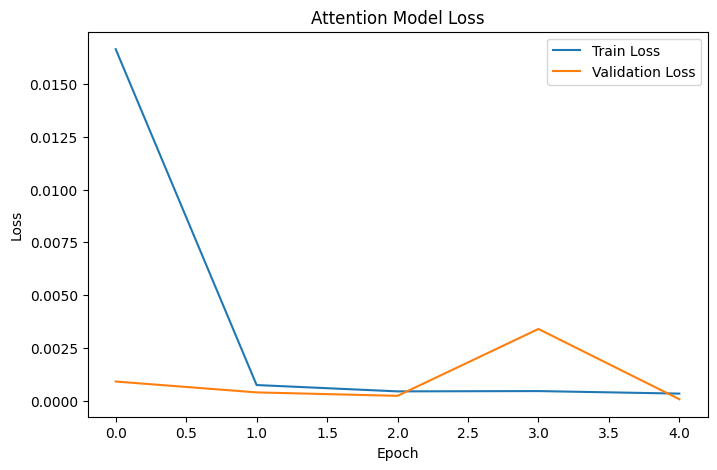

In [15]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history_attn.history['accuracy'], label='Train Accuracy')
plt.plot(history_attn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Attention Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history_attn.history['loss'], label='Train Loss')
plt.plot(history_attn.history['val_loss'], label='Validation Loss')
plt.title('Attention Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
